In [10]:
import numpy as np
import sys
import pickle
from src.interface.audio import AudioClient
from src.model.model import Model
from src.music.score import Pieces

sys.path.append('../../')

from scipy.optimize import curve_fit
from pylab import *

import pandas as pd


In [12]:
audio_client = AudioClient()
model = Model(audio_client, piece=Pieces.Pachabels, tempo=60)

t = 0
q = np.load("../../res/data/Twinkle_Recording.npy")[:, 32:]
counts = []
tempos = []

tempo = model.score.tempo

while tempo < 320:
    count = 0

    while t < len(q[0]):
        obs = q[:, t]
        current_state, prob = model.next_observation(obs)
        t += 1

        if (current_state[0] == 3):
            count += 1

    print(tempo, count)

    counts.append(count)
    tempos.append(tempo)
    tempo += 5
    t = 0
    del model
    model = Model(audio_client, tempo)
    model.score.tempo = tempo

print(counts)
print(tempos)

Model Initialized
60 0
Model Initialized
65 38
Model Initialized
70 38
Model Initialized
75 38
Model Initialized
80 38
Model Initialized
85 38
Model Initialized
90 38
Model Initialized
95 38
Model Initialized
100 38
Model Initialized
105 38
Model Initialized
110 38
Model Initialized
115 38
Model Initialized
120 38
Model Initialized
125 38
Model Initialized
130 38
Model Initialized
135 38
Model Initialized
140 38
Model Initialized
145 38
Model Initialized
150 37
Model Initialized
155 36
Model Initialized
160 35
Model Initialized
165 34
Model Initialized
170 33
Model Initialized
175 32
Model Initialized
180 32
Model Initialized
185 31
Model Initialized
190 30
Model Initialized
195 30
Model Initialized
200 29
Model Initialized
205 28
Model Initialized
210 28
Model Initialized
215 27
Model Initialized
220 26
Model Initialized
225 26
Model Initialized
230 25
Model Initialized
235 25
Model Initialized
240 24
Model Initialized
245 24
Model Initialized
250 23
Model Initialized
255 23
Model Ini

[ 6.21810396e+02 -1.87339506e+03  4.21018069e-04 -2.30381766e+02]


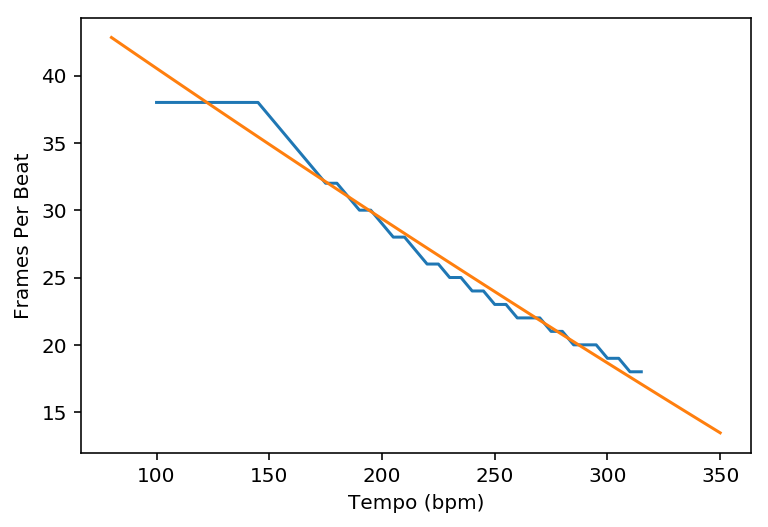

In [13]:
# https://stackoverflow.com/a/21421121

# Put Data into Dataframe
df = pd.DataFrame(list(zip(tempos[8:], counts[8:])), 
               columns =['Tempo', 'Frames Per Beat'])

# Exponential Function
def func(x, a, b, c, d):
    return a*np.exp(-c*(x-b))+d

x = df["Tempo"]
y = df["Frames Per Beat"]

# Fit parameters a,b,c,d
args, _ = curve_fit(func, x, y, [100,400,0.001,0])
print(args)

# Plot against observed values
plot(x,y)
x=linspace(80, 350)
plot(x,func(x,*args))
xlabel("Tempo (bpm)")
ylabel("Frames Per Beat")
show()

In [16]:
def inv_func(y, a, b, c, d):
    return (np.log((y - d)/(a)) / (-c)) + b

print(inv_func(9.5, *args))

with open('tempo_args.pkl', 'wb') as output:
    pickle.dump(args, output, pickle.HIGHEST_PROTOCOL)

158.95051899917462


The problem that I'm running into right now is that I'm not sure why my note durations are not correct.
In other words, if I say that I want my score follower to progress at 60 bpm, i.e. I want a note to last 10 frames, it doesn't.
In practice, it lasts some other amount for which I don't know the relationship/mapping to.

We want a function that, given desired current tempo, produces the correct $a_{0,0}^i$ that produces the desired frames per beat.

Given a tempo and recording speed, we can calculate how many frames a beat is supposed to last. From basic tests, my computer / the current implementation records at around 9.5 frames a second or 570 frames per minute

By fitting the curve of score notated tempo to observed beat duration, we have a function that given a tempo, outputs the frames per beat that will actually occur in the system. It comes in the form

$$f(x) = ae^{-c(x-b)} + d$$

We can take the inverse of this function 

$$x = \frac{ln\left(\frac{y-d}{a}\right)}{-c} + b$$

Which gives us a function that, given how many frames a beat is supposed to last, returns an approximation for the tempo for the system.

With this, we can simply calculate the correct $a_{0,0}^i$, that will make a beat last the desired duration.

$$a_{0,0}^i = 1 - \frac{1}{\frac{s}{x}}$$ 

where $s$ is the recording speed in frames per beat, and $x$ is the system tempo calculated from earlier.


In [17]:
desired_tempo = 60
desired_fpb = 570/desired_tempo

system_tempo = inv_func(desired_fpb, *args)
a_prob = 1 - (system_tempo / 570)

empirical_fpb = func(system_tempo, *args)
print(empirical_fpb, desired_fpb)


9.5 9.5


Comparison between normal tempo and the new tempo that I spent all 
that time converting to doesn't have some trivial linear relationship.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


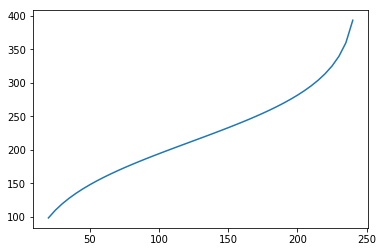

In [18]:
tempo_x = []
tempo_y = []
for tempo in range(20, 300, 5):
    system_tempo = inv_func(570/tempo, *args)
    tempo_x.append(tempo)
    tempo_y.append(system_tempo)

plot(tempo_x, tempo_y)
show()
